In [1]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler
from modules.utils.constants import Stages

/raid6/home/yokoyama/ahar


In [2]:
# set constants
model_type = "ganomaly"
train_data_dir = os.path.join("data", "dataset01", "train")
test_data_dir = os.path.join("data", "dataset01", "test")
data_types = ["bbox", "local"]
seq_len = 300
masking = False

In [3]:
# load results
def load_results(data_dir, model_type, data_type, masking, seq_len, data_keys):
    video_num = os.path.basename(data_dir)
    return IndividualDataHandler.load(data_dir, model_type, data_type, masking, seq_len, data_keys)

data_keys = [IndividualDataFormat.loss_r, IndividualDataFormat.loss_d]
train_results = {}
test_results = {}
for data_type in data_types:
    data_dir = os.path.join(train_data_dir, "10")
    train_results[data_type] = load_results(data_dir, model_type, data_type, masking, seq_len, data_keys)
    data_dir = os.path.join(test_data_dir, "03")
    test_results[data_type] = load_results(data_dir, model_type, data_type, masking, seq_len, data_keys)

In [4]:
def get_results_ind(results):
    ind_results = {}
    for item in results:
        pid = item[IndividualDataFormat.id]
        if pid not in ind_results:
            # initialize individual data
            ind_results[pid] = {
                key: [] for key in IndividualDataFormat.get_keys()
                if key != IndividualDataFormat.id
            }

        # append individual data
        for key, value in item.items():
            if key != IndividualDataFormat.id:
                ind_results[pid][key].append(item[key])
    return ind_results

In [5]:
train_results_ind = {}
test_results_ind = {}
for data_type in data_types:
    train_results_ind[data_type] = get_results_ind(train_results[data_type])
    test_results_ind[data_type] = get_results_ind(test_results[data_type])

In [6]:
def calc_minmax(results):
    maxs = {data_type: {IndividualDataFormat.loss_r: 0, IndividualDataFormat.loss_d: 0} for data_type in data_types}
    mins = {data_type: {IndividualDataFormat.loss_r: 0, IndividualDataFormat.loss_d: 0} for data_type in data_types}
    for data_type, ind_results in results.items(): 
        for ind_result in ind_results.values():
            for key in [IndividualDataFormat.loss_r, IndividualDataFormat.loss_d]:
                val = ind_result[key]
                maxs[data_type][key] = max(maxs[data_type][key], max(val))
                mins[data_type][key] = min(mins[data_type][key], min(val))
    print("max", maxs)
    print("min", mins)
    
print("train")
calc_minmax(train_results_ind)
print("test")
calc_minmax(test_results_ind)

train
max {'bbox': {'loss_resitudal': 0.06646689, 'loss_discrimination': 4.7471374e-05}, 'local': {'loss_resitudal': 0.061669692, 'loss_discrimination': 3.4132972e-07}}
min {'bbox': {'loss_resitudal': 0, 'loss_discrimination': 0}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 0}}
test
max {'bbox': {'loss_resitudal': 0.09098689, 'loss_discrimination': 7.309206e-05}, 'local': {'loss_resitudal': 0.20067677, 'loss_discrimination': 4.1228486e-07}}
min {'bbox': {'loss_resitudal': 0, 'loss_discrimination': 0}, 'local': {'loss_resitudal': 0, 'loss_discrimination': 0}}


In [7]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 20
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

max_frame_num = 5400

def collect_result_value(vals, frame_nums, max_frame_num):
    vals = {f: v for f, v in zip(frame_nums, vals)}
    x, y = [], []
    for frame_num in range(max_frame_num):
        frame_num += 1
        x.append(frame_num)
        if frame_num in frame_nums:
            y.append(vals[frame_num])
        else:
            y.append(np.nan)
    return x, y


def set_ylim(axs):
    i = 0
    axs[i].set_ylim(0.0, 0.1)  # bbox residual
    i += 1
    axs[i].set_ylim(0.0, 0.2)  # local residual


def plot(results, max_frame_num, stage):
    fig, axs = plt.subplots(len(results), 1, figsize=(8, 3 * len(results)))
    fig.subplots_adjust(hspace=0.4, wspace=0.15)
    for i, (data_type, ind_results) in enumerate(results.items()): 
        for pid, results in ind_results.items():
            frame_nums = results[IndividualDataFormat.frame_num]
            loss_resi = results[IndividualDataFormat.loss_r]
            loss_disc = results[IndividualDataFormat.loss_d]

            x_resi, y_resi = collect_result_value(loss_resi, frame_nums, max_frame_num)

            axs[i].plot(x_resi, y_resi, label=pid)
            axs[i].set_xlabel("frame")
            axs[i].set_ylabel("anomaly score")

    axs[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    set_ylim(axs)

    # save fig
    path = os.path.join(
        "data", "images", "medinfo2023", f"{stage}_anomaly.jpg"
    )
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches='tight')

    # show
    plt.show()

# Train Data

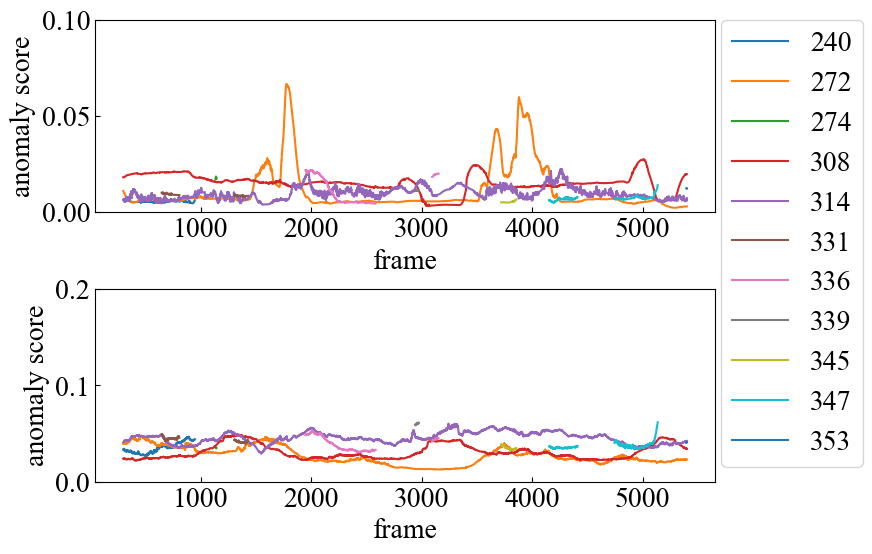

In [8]:
plot(train_results_ind, max_frame_num, "train")

# Test Data

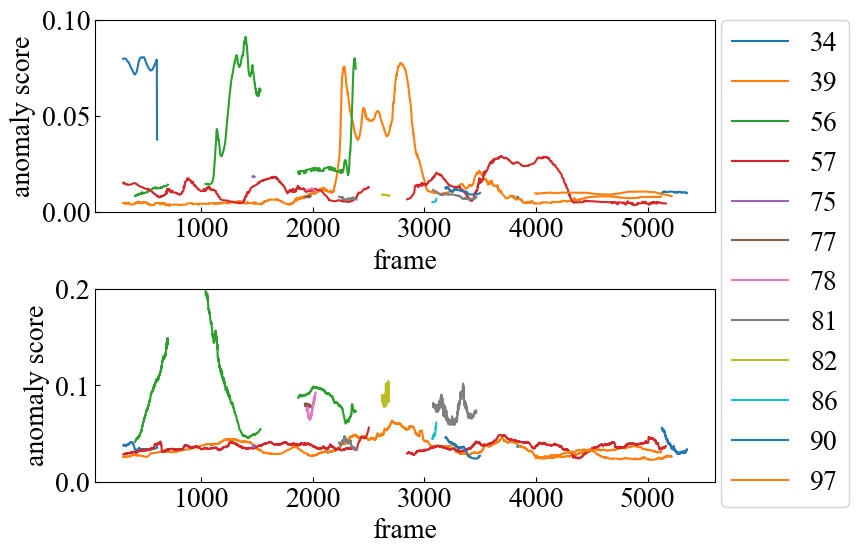

In [9]:
plot(test_results_ind, max_frame_num, "test")